In [371]:
%pip install mesa==2.1.1
%pip install matplotlib
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation  
from mesa.datacollection import DataCollector
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [372]:
from mesa import Agent


class SimpsonAgentStrategic(Agent):
    """
    Agente estratégico usando capas:
    - hazard_grid: EMPTY / SMOKE / FIRE
    - victim_grid: True/False
    - NO entra en casillas con FIRE.
    - Puede apagar FIRE/SMOKE en su casilla o adyacentes ortogonales.
    - Puede cargar víctimas en su casilla y dejarlas en la ambulancia.

    El modelo le da:
    - role: "extinguisher" o "rescuer"
    """

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

        # rol dinámico (lo decide el modelo)
        self.role = "rescuer"

        self.carrying_victim = False

        # plan de alto nivel
        self.current_target = None   # (x, y)
        self.current_path = []       # lista de (x, y) a seguir

        # AP por turno
        self.base_ap = 4

        # stats
        self.victims_picked = 0
        self.victims_rescued = 0
        self.fires_extinguished = 0
        self.smokes_extinguished = 0
        self.doors_opened = 0
        self.action_points = 0

    # =====================
    #  LOOP DEL TURNO
    # =====================
    def step(self):
        if getattr(self.model, "game_over", False):
            return

        ap = self.base_ap
        self.handle_victims()

        # seguridad contra loops raros
        max_iters = self.base_ap * 4

        for _ in range(max_iters):
            if ap <= 0:
                break

            # --- 1) modo "llevar a la ambulancia" si cargo víctima ---
            if self.carrying_victim and self.pos != self.model.ambulance_pos:
                # objetivo fijo = ambulancia
                if self.current_target != self.model.ambulance_pos:
                    self.current_target = self.model.ambulance_pos
                    self.current_path = []
                    self.plan_path_to_target()
            else:
                # --- 2) modo normal (extinguisher / rescuer) ---
                if (not self.current_target) or (not self.is_target_still_valid()):
                    self.plan_new_target()

            # si aun así no tengo objetivo → intento apagar local y paro
            if not self.current_target:
                ap = self.try_local_actions(ap)
                break

            # necesito ruta
            if not self.current_path:
                self.plan_path_to_target()

            # 🔧 ARREGLO IMPORTANTE:
            # Si no hay ruta PERO ya estoy parado en el target,
            # significa que el objetivo es mi propia casilla (p.ej. SMOKE debajo).
            # En vez de descartar el target, actuamos localmente.
            if not self.current_path:
                if self.current_target and self.pos == self.current_target:
                    ap = self.try_local_actions(ap)
                    self.current_target = None
                    self.current_path = []
                    continue  # pasar a la siguiente iteración del turno
                # objetivo imposible → lo soltamos
                self.current_target = None
                continue

            # siguiente casilla de la ruta
            next_pos = self.current_path[0]
            ap_before = ap
            ap = self.move_towards(next_pos, ap)

            if ap == ap_before:
                # no me pude mover, descarto ruta/objetivo
                self.current_path = []
                self.current_target = None
                continue

            # avance exitoso
            self.current_path.pop(0)
            self.handle_victims()

            # si llegué al objetivo, intento acciones locales y reseteo objetivo
            if self.current_target and self.pos == self.current_target:
                ap = self.try_local_actions(ap)
                self.current_target = None
                self.current_path = []

    # =====================
    #  OBJETIVOS
    # =====================
    def is_target_still_valid(self):
        """
        El objetivo es válido si:
        - extinguisher: sigue habiendo FIRE/SMOKE en hazard_grid.
        - rescuer: sigue habiendo víctima en victim_grid.
        - y no está reclamado por otro agente.
        """
        if self.current_target is None:
            return False

        x, y = self.current_target
        if not (0 <= x < self.model.width and 0 <= y < self.model.height):
            return False

        # si otro agente ya lo reclamó, lo soltamos
        if hasattr(self.model, "is_target_taken_by_other"):
            if self.model.is_target_taken_by_other((x, y), self.unique_id):
                return False

        hazard = self.model.hazard_grid[x, y]
        has_victim = self.model.victim_grid[x, y]

        if self.role == "extinguisher":
            return hazard in (self.model.FIRE, self.model.SMOKE)
        elif self.role == "rescuer":
            # si cargamos víctima, el target debería ser la ambulancia,
            # así que este caso aplica solo cuando NO cargamos
            return has_victim

        return False

    def plan_new_target(self):
        """
        Busca un nuevo objetivo con BFS en TODO el mapa:
        - extinguisher: FIRE/SMOKE
        - rescuer: VICTIM (victim_grid[x,y] == True)
        Evita objetivos ya reclamados.
        """
        self.current_target = None
        self.current_path = []

        target = self._bfs_find_target()
        if target is not None:
            self.current_target = target
            if hasattr(self.model, "claim_target"):
                self.model.claim_target(target, self.unique_id)

    def _bfs_find_target(self):
        """
        BFS sobre todo el grid (sin zonas).
        Usa:
        - hazard_grid para fuego/humo
        - victim_grid para víctimas
        - edges para no cruzar walls

        Además:
        - cuando encuentra un candidato, verifica con A* si es alcanzable.
        """
        start = self.pos

        visited = set([start])
        queue = [start]

        while queue:
            x, y = queue.pop(0)
            pos = (x, y)

            hazard = self.model.hazard_grid[x, y]
            has_victim = self.model.victim_grid[x, y]

            # ¿esta celda es objetivo?
            is_candidate = False
            if self.role == "extinguisher":
                if hazard in (self.model.FIRE, self.model.SMOKE):
                    if not self._target_taken_by_other(pos):
                        is_candidate = True
            elif self.role == "rescuer" and not self.carrying_victim:
                if has_victim:
                    if not self._target_taken_by_other(pos):
                        is_candidate = True

            if is_candidate:
                # Verificar que realmente haya ruta con A*
                if hasattr(self.model, "astar_path"):
                    path = self.model.astar_path(start, pos)
                else:
                    path = None

                if path and len(path) > 0:
                    return pos
                # si no hay ruta, seguimos buscando

            # expandir BFS
            for nx, ny in ((x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)):
                if (nx, ny) in visited:
                    continue
                if not (0 <= nx < self.model.width and 0 <= ny < self.model.height):
                    continue

                edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue

                visited.add((nx, ny))
                queue.append((nx, ny))

        return None

    def _target_taken_by_other(self, pos):
        if hasattr(self.model, "is_target_taken_by_other"):
            return self.model.is_target_taken_by_other(pos, self.unique_id)
        return False

    # =====================
    #  RUTA (A*)
    # =====================
    def plan_path_to_target(self):
        """
        Usa A* definido en el modelo: astar_path(start, goal).
        A* debe considerar:
        - no cruzar walls
        - no entrar a FIRE
        """
        if self.current_target is None:
            self.current_path = []
            return

        if not hasattr(self.model, "astar_path"):
            self.current_path = []
            return

        start = self.pos
        goal = self.current_target
        path = self.model.astar_path(start, goal)

        if path is None:
            self.current_path = []
        else:
            if path and path[0] == start:
                path = path[1:]
            self.current_path = path

    # =====================
    #  MOVIMIENTO
    # =====================
    def move_towards(self, next_pos, ap):
        """
        Moverse a next_pos respetando:
        - no entrar a FIRE (hazard_grid)
        - walls bloquean
        - door_closed se puede abrir (1 AP) y luego mover
        - costo: 1 sin víctima, 2 con víctima
        """
        if ap <= 0:
            return ap

        x, y = self.pos
        nx, ny = next_pos

        if not (0 <= nx < self.model.width and 0 <= ny < self.model.height):
            return ap

        edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")
        if edge_type == "wall":
            return ap

        hazard = self.model.hazard_grid[nx, ny]

        # no entrar a fuego
        if hazard == self.model.FIRE:
            return ap

        move_cost = 2 if self.carrying_victim else 1
        door_cost = 1 if edge_type == "door_closed" else 0
        total_cost = move_cost + door_cost

        if total_cost > ap:
            return ap

        # abrir puerta si es necesario
        if edge_type == "door_closed":
            if hasattr(self.model, "set_edge"):
                self.model.set_edge((x, y), (nx, ny), "door_open")
            self.doors_opened += 1
            self.action_points += 1
            ap -= 1

        # mover agente
        self.model.grid.move_agent(self, (nx, ny))
        self.action_points += move_cost
        ap -= move_cost

        return ap

    # =====================
    #  ACCIONES LOCALES (APAGAR)
    # =====================
    def try_local_actions(self, ap):
        """
        Intenta apagar en su casilla o vecinas ortogonales.
        Usa hazard_grid:
        - SMOKE: 1 AP para limpiar
        - FIRE: 2 AP para limpiar; o 1 AP para bajarlo a SMOKE si solo queda 1 AP
        """
        if ap <= 0:
            return ap

        x, y = self.pos
        positions = [(x, y)] + self.model.grid.get_neighborhood(
            (x, y), moore=False, include_center=False
        )

        for tx, ty in positions:
            if not (0 <= tx < self.model.width and 0 <= ty < self.model.height):
                continue

            hazard = self.model.hazard_grid[tx, ty]

            if hazard == self.model.SMOKE:
                if ap >= 1:
                    self.model.hazard_grid[tx, ty] = self.model.EMPTY
                    self.smokes_extinguished += 1
                    self.action_points += 1
                    return ap - 1

            elif hazard == self.model.FIRE:
                if ap >= 2:
                    self.model.hazard_grid[tx, ty] = self.model.EMPTY
                    self.fires_extinguished += 1
                    self.action_points += 2
                    return ap - 2
                elif ap == 1:
                    self.model.hazard_grid[tx, ty] = self.model.SMOKE
                    self.smokes_extinguished += 1
                    self.action_points += 1
                    return ap - 1

        return ap

    # =====================
    #  VÍCTIMAS (victim_grid)
    # =====================
    def handle_victims(self):
        """
        - Si hay víctima en victim_grid[x,y] y no cargo a nadie → la recoge.
        - Si cargo víctima y estoy en ambulancia → la rescato y el modelo genera una nueva.
        """
        x, y = self.pos

        # recoger víctima en la casilla
        if self.model.victim_grid[x, y] and not self.carrying_victim:
            self.carrying_victim = True
            self.model.victim_grid[x, y] = False
            self.victims_picked += 1

        # rescatar si estoy en la ambulancia
        if self.carrying_victim and (x, y) == self.model.ambulance_pos:
            self.carrying_victim = False
            self.victims_rescued += 1
            if hasattr(self.model, "victims_rescued_total"):
                self.model.victims_rescued_total += 1
            if hasattr(self.model, "victims_update"):
                self.model.victims_update(1)


In [373]:
import random
import numpy as np
from mesa import Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import heapq


class SimpsonStrategicModel(Model):
    # Visual/legacy codes (para tu colormap)
    EMPTY = 0
    FIRE = 1
    SMOKE = 2
    VICTIM = 3
    DOOR_CLOSED = 4
    DOOR_OPEN = 5
    AMBULANCE = 6
    FIREFIGHTER = 7
    VICTIM_SMOKE = 8  # víctima en celda con humo (solo viz)

    def __init__(
        self,
        width=10,
        height=10,
        num_firefighters=6,
        num_fires=10,
        num_smokes=0,
        num_victims=4,
        num_doors=11,
        num_walls=24,
        wall_hp=2,
        seed=None,

        # ---- layout manual (MISMO que el random) ----
        use_random_edges=True,
        walls=[
            ((0,2), (1,2), 2),
            ((0,3), (1,3), 2),
            ((0,4), (1,4), 2),
            ((0,5), (1,5), 2),
            ((0,6), (1,6), 2),
            ((0,7), (1,7), 2),
            ((1,8), (1,7), 2),
            ((2,8), (2,7), 2),
            ((4,8), (4,7), 2),
            ((5,8), (5,7), 2),
            ((5,8), (6,8), 2),
            ((6,9), (6,8), 2),
            ((7,9), (7,8), 2),
            ((9,8), (8,8), 2),
            ((9,7), (8,7), 2),
            ((9,6), (8,6), 2),
            ((9,5), (8,5), 2),
            ((9,3), (8,3), 2),
            ((9,2), (8,2), 2),
            ((8,2), (8,1), 2),
            ((7,2), (7,1), 2),
            ((7,1), (6,1), 2),
            ((6,1), (6,0), 2),
            ((5,1), (5,0), 2),
            ((4,1), (4,0), 2),
            ((3,1), (3,0), 2),
            ((3,1), (2,1), 2),
            ((1,2), (1,1), 2), # Aqui acaban las paredes exteriores
            ((1,5), (1,4), 2),
            ((3,5), (3,4), 2),
            ((4,5), (4,4), 2),
            ((6,5), (6,4), 2),
            ((8,5), (8,4), 2),
            ((3,7), (2,7), 2),
            ((3,5), (2,5), 2),
            ((3,4), (2,4), 2),
            ((3,3), (2,3), 2),
            ((3,2), (2,2), 2),
            ((4,7), (3,7), 2),
            ((4,5), (3,5), 2),
            ((6,8), (5,8), 2),
            ((6,7), (5,7), 2),
            ((6,6), (5,6), 2),
            ((6,5), (5,5), 2),
            ((6,3), (5,3), 2),
            ((6,2), (5,2), 2),
            ((6,1), (5,1), 2),
            ((7,3), (6,3), 2),
            ((7,2), (6,2), 2),
            ((8,3), (8,4), 2),
        ],       
        doors_closed=[
            ((3,8), (3,7)),
            ((8,9), (8,8)),
            ((9,4), (8,4)),
            ((2,2), (2,1)), # Aqui acaban las puertas exteriores
            ((2,5), (2,4)),
            ((5,5), (5,4)),
            ((7,5), (7,4)),
            ((3,6), (2,6)),
            ((4,6), (3,6)),
            ((6,4), (5,4)),
            ((7,3), (7,4)),
        ], 
        doors_open=None,  
    ):
        super().__init__()
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            self.random.seed(seed)

        self.width = width
        self.height = height

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)

        # --- CAPAS ---
        self.hazard_grid = np.zeros((width, height), dtype=np.int8)   # 0 empty / 1 fire / 2 smoke
        self.victim_grid = np.zeros((width, height), dtype=bool)      # víctimas pueden coexistir con smoke
        self.static_grid = np.zeros((width, height), dtype=np.int8)   # ambulancia, etc.

        self.ambulance_pos = (0, 0)
        self.static_grid[self.ambulance_pos] = self.AMBULANCE


        # --- EDGES ---
        self.edges = {}
        self.wall_hp_default = wall_hp
        self.wall_hp = {}  # key=(sorted(pos_a,pos_b)) -> int hp

        self.wall_damaged_total = 0  # contador de daños a paredes

        self._init_edges_empty()

        # Si te pasan listas manuales, por default usamos manual
        if walls or doors_closed or doors_open:
            use_random_edges = False

        if use_random_edges:
            self._randomly_place_edges(num_walls, "wall", wall_hp=wall_hp)
            self._randomly_place_edges(num_doors, "door_closed")
        else:
            self.apply_manual_edges(walls=walls, doors_closed=doors_closed, doors_open=doors_open)

        self.inside_cells = self._compute_inside_cells()

        self._randomly_place_hazards(num_fires, self.FIRE)
        self._randomly_place_hazards(num_smokes, self.SMOKE)
        self._randomly_place_victims(num_victims)

        # --- agentes estratégicos ---
        for i in range(num_firefighters):
            self._add_firefighter(i)

        # Estado global
        self.victims_rescued_total = 0
        self.victims_dead_total = 0
        self.game_over = False
        self.game_result = None

        # Grid combinado para visualización
        self.env_grid = self.get_base_visual_grid()

        # Objetivos reclamados por turno
        self.claimed_targets = {}

        self.datacollector = DataCollector(
            model_reporters={
                "total_victims_picked": lambda m: sum(a.victims_picked for a in m.schedule.agents),
                "total_victims_rescued": lambda m: sum(a.victims_rescued for a in m.schedule.agents),
                "total_fires_extinguished": lambda m: sum(a.fires_extinguished for a in m.schedule.agents),
                "total_smokes_extinguished": lambda m: sum(a.smokes_extinguished for a in m.schedule.agents),
                "total_doors_opened": lambda m: sum(a.doors_opened for a in m.schedule.agents),
                "total_action_points": lambda m: sum(a.action_points for a in m.schedule.agents),
                "total_walls_broken": lambda m: sum(getattr(a, "walls_broken", 0) for a in m.schedule.agents),
                "victims_rescued_total": "victims_rescued_total",
                "victims_dead_total": "victims_dead_total",
                "wall_damaged_total": lambda m: m.wall_damaged_total,
            },
            agent_reporters={
                "victims_picked": "victims_picked",
                "victims_rescued": "victims_rescued",
                "fires_extinguished": "fires_extinguished",
                "smokes_extinguished": "smokes_extinguished",
                "doors_opened": "doors_opened",
                "action_points": "action_points",
                "walls_broken": lambda a: getattr(a, "walls_broken", 0),
                "role": lambda a: getattr(a, "role", None),
            },
        )

    # -----------------------
    # Visual
    # -----------------------
    def sync_env_grid(self):
        self.env_grid = self.get_base_visual_grid()

    def get_base_visual_grid(self):
        vis = np.zeros((self.width, self.height), dtype=np.int16)

        ax, ay = self.ambulance_pos
        vis[ax, ay] = self.AMBULANCE

        vis[self.hazard_grid == self.SMOKE] = self.SMOKE
        vis[self.hazard_grid == self.FIRE] = self.FIRE

        vmask = self.victim_grid
        vis[vmask] = self.VICTIM

        smoke_victim = (self.hazard_grid == self.SMOKE) & vmask
        vis[smoke_victim] = self.VICTIM_SMOKE

        vis[self.hazard_grid == self.FIRE] = self.FIRE
        vis[ax, ay] = self.AMBULANCE
        return vis

    def get_visual_grid(self):
        vis = self.get_base_visual_grid()
        for agent in self.schedule.agents:
            x, y = agent.pos
            vis[x, y] = self.FIREFIGHTER
        return vis

    # -----------------------
    # Edges / HP + MANUAL
    # -----------------------
    def edge_key(self, pos_a, pos_b):
        return tuple(sorted([pos_a, pos_b]))

    def _assert_adjacent(self, a, b):
        if abs(a[0]-b[0]) + abs(a[1]-b[1]) != 1:
            raise ValueError(f"Edge inválido (no son vecinos ortogonales): {a} <-> {b}")
        for (x, y) in (a, b):
            if not (0 <= x < self.width and 0 <= y < self.height):
                raise ValueError(f"Posición fuera del grid: {(x,y)}")

    def set_edge(self, pos_a, pos_b, edge_type):
        self.edges[(pos_a, pos_b)] = edge_type
        self.edges[(pos_b, pos_a)] = edge_type

        # si dejamos de ser pared, limpiamos HP
        if edge_type != "wall":
            k = self.edge_key(pos_a, pos_b)
            if k in self.wall_hp:
                del self.wall_hp[k]

    def add_wall(self, a, b, hp=None):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "wall")
        self.wall_hp[self.edge_key(a, b)] = int(self.wall_hp_default if hp is None else hp)

    def add_door_closed(self, a, b):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_closed")

    def add_door_open(self, a, b):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_open")

    def apply_manual_edges(self, walls=None, doors_closed=None, doors_open=None):
        walls = walls or []
        doors_closed = doors_closed or []
        doors_open = doors_open or []

        for item in walls:
            # permite ((a,b)) o ((a,b,hp))
            if len(item) == 2:
                a, b = item
                hp = None
            else:
                a, b, hp = item
            self.add_wall(a, b, hp=hp)

        for a, b in doors_closed:
            self.add_door_closed(a, b)

        for a, b in doors_open:
            self.add_door_open(a, b)

    def _init_edges_empty(self):
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        to_pos = (nx, ny)
                        if (from_pos, to_pos) not in self.edges:
                            self.set_edge(from_pos, to_pos, "empty")

    def _randomly_place_edges(self, count, edge_type, wall_hp=None):
        all_pairs = []
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        all_pairs.append((from_pos, (nx, ny)))

        self.random.shuffle(all_pairs)

        placed = 0
        for from_pos, to_pos in all_pairs:
            if placed >= count:
                break
            current = self.edges.get((from_pos, to_pos), "empty")
            if current == "empty":
                self.set_edge(from_pos, to_pos, edge_type)
                if edge_type == "wall":
                    hp_val = self.wall_hp_default if wall_hp is None else wall_hp
                    self.wall_hp[self.edge_key(from_pos, to_pos)] = int(hp_val)
                placed += 1

    def can_move(self, from_pos, to_pos):
        fx, fy = from_pos
        tx, ty = to_pos

        if abs(tx - fx) + abs(ty - fy) != 1:
            return False

        if tx < 0 or tx >= self.width or ty < 0 or ty >= self.height:
            return False

        edge_type = self.edges.get((from_pos, to_pos), "empty")
        if edge_type in ("wall", "door_closed"):
            return False
        return True

    def damage_wall(self, from_pos, to_pos, dmg=1):
        if self.edges.get((from_pos, to_pos), "empty") != "wall":
            return False

        k = self.edge_key(from_pos, to_pos)
        if k not in self.wall_hp:
            self.wall_hp[k] = self.wall_hp_default

        self.wall_damaged_total += int(dmg)
        self.wall_hp[k] -= int(dmg)

        if self.wall_hp[k] <= 0:
            self.set_edge(from_pos, to_pos, "empty")
            return True
        return False
    

    def _compute_inside_cells(self):
        from collections import deque

        outside = set()
        d = deque()

        for x in range(self.width):
            for y in range(self.height):
                if x == 0 or x == self.width - 1 or y == 0 or y == self.height - 1:
                    outside.add((x, y))
                    d.append((x, y))

        while d:
            x, y = d.popleft()

            neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
            for nx, ny in neighbors:
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    continue
                if (nx, ny) in outside:
                    continue

                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type in ("wall", "door_closed"):
                    continue

                outside.add((nx, ny))
                d.append((nx, ny))

        inside = [
            (x, y)
            for x in range(self.width)
            for y in range(self.height)
            if (x, y) not in outside
        ]

        return inside

    # -----------------------
    # Colocación inicial (capas)
    # -----------------------
    def _randomly_place_hazards(self, count, code):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.EMPTY:
                self.hazard_grid[x, y] = code
                placed += 1

    def _randomly_place_victims(self, count):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1

    def _add_firefighter(self, i):
        """
        Igual que en el random, pero usa SimpsonAgentStrategic.
        """
        from math import inf  # por si acaso

        all_cells = [
            (2,9), (3,9), (4,9),
            (0,0), (1,0), (2,0),
            (9,3), (9,4), (9,5),
        ]  
    

        for x, y in all_cells:
            if (x, y) == self.ambulance_pos:
                continue
            if self.grid.is_cell_empty((x, y)) and self.hazard_grid[x, y] == self.EMPTY and not self.victim_grid[x, y]:
                agent = SimpsonAgentStrategic(self.next_id(), self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                break

    # -----------------------
    # Víctimas / fuego / humo
    # -----------------------
    def victims_update(self, num_victims=1):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= num_victims:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1

    def apply_fire_to_cell(self, x, y):
        if (x, y) == self.ambulance_pos:
            return

        if self.victim_grid[x, y]:
            self.victim_grid[x, y] = False
            self.victims_dead_total += 1
            self.victims_update(1)

        if self.hazard_grid[x, y] in (self.EMPTY, self.SMOKE):
            self.hazard_grid[x, y] = self.FIRE

    def explosion(self, x, y, exploded=None):
        if exploded is None:
            exploded = set()
        if (x, y) in exploded:
            return
        exploded.add((x, y))

        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue

            edge_type = self.edges.get(((x, y), (nx, ny)), "empty")

            # pared: daña; si NO se rompe, bloquea fuego
            if edge_type == "wall":
                if not self.damage_wall((x, y), (nx, ny), dmg=1):
                    continue

            # puertas: se destruyen (cerradas o abiertas)
            if edge_type in ("door_closed", "door_open"):
                self.set_edge((x, y), (nx, ny), "empty")

            had_fire = (self.hazard_grid[nx, ny] == self.FIRE)
            self.apply_fire_to_cell(nx, ny)

            if had_fire and (nx, ny) not in exploded:
                self.explosion(nx, ny, exploded)

    def smoke_adjacent_to_fire(self, x, y):
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue
            if self.hazard_grid[nx, ny] == self.FIRE:
                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue
                self.apply_fire_to_cell(x, y)
                return True
        return False

    def new_fire(self):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        for x, y in all_cells:
            if (x, y) == self.ambulance_pos:
                continue

            h = self.hazard_grid[x, y]

            if h == self.EMPTY:
                self.hazard_grid[x, y] = self.SMOKE
                self.smoke_adjacent_to_fire(x, y)
                break
            elif h == self.SMOKE:
                self.apply_fire_to_cell(x, y)
                break
            elif h == self.FIRE:
                self.explosion(x, y)
                break

    # -----------------------
    # ROLES GLOBALES (2 o 4 extinguisher)
    # -----------------------
    def assign_roles_global(self):
        """
        Estrategia pedida:
        - Si hay poco fuego: 2 bomberos apagan, el resto rescata.
        - Si hay mucho fuego: 4 bomberos apagan, el resto rescata.
        Aquí definimos:
        - poco fuego  = <= 4 fuegos
        - mucho fuego = > 4 fuegos
        """
        agents = list(self.schedule.agents)
        total_fires = int(np.sum(self.hazard_grid == self.FIRE))

        if total_fires == 0:
            # todos a rescatar
            for a in agents:
                a.role = "rescuer"
            return

        FIRE_LOW = 4  # puedes ajustar este umbral

        if total_fires <= FIRE_LOW:
            num_extinguishers = min(2, len(agents))
        else:
            num_extinguishers = min(4, len(agents))

        # por simplicidad: los primeros N apagan, el resto rescata
        for idx, a in enumerate(agents):
            if idx < num_extinguishers:
                a.role = "extinguisher"
            else:
                a.role = "rescuer"

    # -----------------------
    # OBJETIVOS COMPARTIDOS
    # -----------------------
    def reset_claimed_targets(self):
        self.claimed_targets = {}

    def claim_target(self, pos, agent_id):
        self.claimed_targets[pos] = agent_id

    def is_target_taken_by_other(self, pos, agent_id):
        owner = self.claimed_targets.get(pos)
        return owner is not None and owner != agent_id

    # -----------------------
    # A* SOBRE CAPAS
    # -----------------------
    def astar_path(self, start, goal):
        """
        A* para el modelo estratégico:
        - No cruza walls.
        - Permite puertas open/closed.
        - No entra a FIRE.
        - Límite de expansiones para evitar loops infinitos.
        """
        if start == goal:
            return [start]

        def heuristic(a, b):
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        open_set = []
        heapq.heappush(open_set, (heuristic(start, goal), 0, start))
        came_from = {}
        g_score = {start: 0}

        max_expansions = 300
        expansions = 0

        while open_set:
            expansions += 1
            if expansions > max_expansions:
                return None

            f, g, current = heapq.heappop(open_set)
            if current == goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return path

            x, y = current
            for nx, ny in ((x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)):
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    continue

                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue

                # no entrar a fuego
                if self.hazard_grid[nx, ny] == self.FIRE:
                    continue

                neighbor = (nx, ny)
                tentative_g = g + 1

                if tentative_g < g_score.get(neighbor, float("inf")):
                    g_score[neighbor] = tentative_g
                    came_from[neighbor] = current
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, tentative_g, neighbor))

        return None

    # -----------------------
    # Game loop
    # -----------------------
    def check_game_over(self):
        if self.game_over:
            return

        mask = np.ones((self.width, self.height), dtype=bool)
        ax, ay = self.ambulance_pos
        mask[ax, ay] = False
        if np.all(self.hazard_grid[mask] == self.FIRE):
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: todo el edificio está en llamas.")
            return
        
        if self.wall_damaged_total >= 24:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: perdiste por dañar demasiadas paredes.")
            return

        if self.victims_rescued_total >= 7:
            self.game_over = True
            self.game_result = "win"
            print("Game Over: ganaste por rescatar suficientes víctimas.")
        elif self.victims_dead_total >= 4:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: perdiste por demasiadas víctimas muertas.")

    def step(self):
        if self.game_over:
            return

        # roles globales según cantidad de fuego
        self.reset_claimed_targets()
        self.assign_roles_global()

        # agentes actúan (cada uno con BFS + A*)
        self.schedule.step()

        # fuego / humo / explosiones
        self.new_fire()
        self.check_game_over()

        self.sync_env_grid()
        self.datacollector.collect(self)


In [374]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from IPython.display import HTML, display

# (Opcional pero recomendado en notebooks) fuerza salida HTML/JS en vez de imagen estática
from matplotlib import rc
rc("animation", html="jshtml")

# Fallback por si no tienes colors/cmap definidos en tu notebook
try:
    cmap
    colors
except NameError:
    from matplotlib.colors import ListedColormap
    colors = ["white", "red", "orange", "blue", "black", "gray", "green", "magenta"]
    cmap = ListedColormap(colors)


def _agents_list(model):
    # Mesa 3.x: model.agents; versiones viejas: schedule.agents
    if hasattr(model, "agents"):
        return list(model.agents)
    if hasattr(model, "schedule"):
        return list(model.schedule.agents)
    return []


def edge_segments(model):
    """
    Convierte model.edges (entre celdas) a segmentos de línea para dibujar encima del grid.
    Retorna: (walls, doors_closed, doors_open) como listas de segmentos.
    Cada segmento: [(x1,y1),(x2,y2)]
    """
    walls, doors_closed, doors_open = [], [], []

    for x in range(model.width):
        for y in range(model.height):
            # borde entre (x,y) y (x+1,y) => línea vertical en x+0.5
            if x + 1 < model.width:
                t = model.edges.get(((x, y), (x + 1, y)), "empty")
                seg = [(x + 0.5, y - 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

            # borde entre (x,y) y (x,y+1) => línea horizontal en y+0.5
            if y + 1 < model.height:
                t = model.edges.get(((x, y), (x, y + 1)), "empty")
                seg = [(x - 0.5, y + 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

    return walls, doors_closed, doors_open

def run_one_game(seed, max_steps=500):
    """
    Corre una sola simulación con la seed dada.
    Regresa (resultado, steps)
    """
    model = SimpsonStrategicModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,
        seed=seed,
    )
    
    while (not model.game_over) and (model.schedule.steps < max_steps):
        model.step()
    
    result = getattr(model, "game_result", None)
    steps = getattr(model.schedule, "steps", None)
    return result, steps

def run_many_games(n_games=50, base_seed=0, max_steps=500, verbose=False):
    """
    Corre n_games simulaciones, cambiando la seed cada vez.
    Regresa un diccionario con estadísticas.
    """
    stats = {
        "games": n_games,
        "wins": 0,
        "losses": 0,
        "other": 0,      # empates / errores / lo que no matchee
        "total_steps": 0
    }
    
    results_list = []
    
    for i in range(n_games):
        seed = base_seed + i
        result, steps = run_one_game(seed=seed, max_steps=max_steps)
        
        # guarda pasos
        if steps is not None:
            stats["total_steps"] += steps
        
        # clasifica resultado (ajusta strings a lo que uses en tu modelo)
        if isinstance(result, str):
            r_low = result.lower()
            if "win" in r_low or "victory" in r_low or "gan" in r_low:   # por si pones "ganó", etc
                stats["wins"] += 1
            elif "lose" in r_low or "derrota" in r_low or "perd" in r_low:
                stats["losses"] += 1
            else:
                stats["other"] += 1
        else:
            stats["other"] += 1
        
        results_list.append((seed, result, steps))
        
        if verbose:
            print(f"Game {i+1}/{n_games} | seed={seed} | result={result} | steps={steps}")
    
    # métricas derivadas
    if n_games > 0:
        stats["win_rate"] = stats["wins"] / n_games
        stats["loss_rate"] = stats["losses"] / n_games
        stats["avg_steps"] = stats["total_steps"] / n_games
    else:
        stats["win_rate"] = 0
        stats["loss_rate"] = 0
        stats["avg_steps"] = 0
    
    # También regreso la lista detallada por si quieres analizar luego
    return stats, results_list


def animate_with_edges(model, steps=80, interval=300, show_open_doors=True):
    """
    - Fondo: env_grid
    - Encima: bomberos como scatter
    - Encima: paredes/puertas (edges) como LineCollections
    Devuelve HTML listo para mostrar en Jupyter.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Fondo (usamos .T para mantener tu orientación)
    bg = ax.imshow(
        model.env_grid.T,
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        origin="upper",
    )

    # Colores distintos para cada agente (por índice)
    agent_colors = ["blue", "cyan", "magenta", "yellow", "lime", "orange", "pink", "purple"]

    # 🔴 Extinguishers → círculos
    sc_ext = ax.scatter(
        [], [], s=140, c=[],
        marker="o", edgecolors="black", linewidths=1.5, zorder=5
    )

    # 🟦 Rescuers → cuadrados
    sc_res = ax.scatter(
        [], [], s=140, c=[],
        marker="s", edgecolors="black", linewidths=1.5, zorder=5
    )

    # Indicador de bomberos con víctimas (anillo grande)
    sc_carrying = ax.scatter(
        [], [], s=250, c="none",
        marker="o", edgecolors="lime", linewidths=4, alpha=0.9, zorder=4
    )

    # Víctimas (triángulos verdes)
    sc_victims = ax.scatter(
        [], [], s=120, c="green",
        marker="^", edgecolors="white", linewidths=2, zorder=3
    )

    # Límites alineados a bordes de celdas
    ax.set_xlim(-0.5, model.width - 0.5)
    ax.set_ylim(model.height - 0.5, -0.5)  # origen arriba (coincide con origin="upper")
    ax.set_aspect("equal")

    # Ticks principales
    ax.set_xticks(range(model.width))
    ax.set_yticks(range(model.height))

    # Ticks menores en bordes de celda (-0.5, 0.5, 1.5, ...)
    ax.set_xticks(np.arange(-0.5, model.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.height, 1), minor=True)

    # Grid sobre bordes de celdas (minor)
    ax.grid(which="minor", linewidth=0.7)
    ax.grid(which="major", linewidth=0)

    # Colecciones de líneas (paredes/puertas)
    walls, dc, do = edge_segments(model)

    lc_w = LineCollection(walls, colors="black", linewidths=3)       # paredes
    lc_dc = LineCollection(dc, colors="#00E5FF", linewidths=3)       # puertas cerradas (cyan)
    ax.add_collection(lc_w)
    ax.add_collection(lc_dc)

    lc_do = None
    if show_open_doors:
        lc_do = LineCollection(
            do, colors="#FFD400", linewidths=2, linestyles="dashed"
        )  # puertas abiertas
        ax.add_collection(lc_do)

    ax.set_title("Simpson Flashpoint — paredes/puertas + agentes")

    def update(frame):
        # 1) SNAPSHOT
        grid_snapshot = model.env_grid.T.copy()

        # 2) DIBUJAR snapshot reemplazando víctimas con lo que hay debajo
        grid_display = grid_snapshot.copy()

        victim_positions = []
        for x in range(model.width):
            for y in range(model.height):
                if model.victim_grid[x, y]:
                    victim_positions.append((x, y))
                    if model.env_grid[x, y] == model.VICTIM_SMOKE:
                        grid_display[y, x] = model.SMOKE  # humo debajo
                    else:
                        grid_display[y, x] = model.EMPTY  # blanco debajo

        bg.set_data(grid_display)

        # Dibujar víctimas
        if victim_positions:
            vxs = [pos[0] for pos in victim_positions]
            vys = [pos[1] for pos in victim_positions]
            sc_victims.set_offsets(np.c_[vxs, vys])
        else:
            sc_victims.set_offsets(np.empty((0, 2)))

        # ===== AGENTES (separados por rol) =====
        agents = _agents_list(model)

        ext_pos, ext_cols = [], []
        res_pos, res_cols = [], []

        for i, a in enumerate(agents):
            x, y = a.pos
            col = agent_colors[i % len(agent_colors)]
            if getattr(a, "role", "rescuer") == "extinguisher":
                ext_pos.append((x, y))
                ext_cols.append(col)
            else:
                res_pos.append((x, y))
                res_cols.append(col)

        # Extinguishers → círculos
        if ext_pos:
            sc_ext.set_offsets(np.array(ext_pos))
            sc_ext.set_color(ext_cols)
        else:
            sc_ext.set_offsets(np.empty((0, 2)))

        # Rescuers → cuadrados
        if res_pos:
            sc_res.set_offsets(np.array(res_pos))
            sc_res.set_color(res_cols)
        else:
            sc_res.set_offsets(np.empty((0, 2)))

        # Indicador de agentes con víctimas (anillo verde grande)
        agents_with_victims = [(a.pos[0], a.pos[1]) for a in agents if a.carrying_victim]
        if agents_with_victims:
            vx_carrier = [pos[0] for pos in agents_with_victims]
            vy_carrier = [pos[1] for pos in agents_with_victims]
            sc_carrying.set_offsets(np.c_[vx_carrier, vy_carrier])
        else:
            sc_carrying.set_offsets(np.empty((0, 2)))

        # Actualizar paredes/puertas
        walls, dc, do = edge_segments(model)
        lc_w.set_segments(walls)
        lc_dc.set_segments(dc)
        if lc_do is not None:
            lc_do.set_segments(do)

        # Mostrar estadísticas en el título
        status = ""
        if model.game_over:
            if model.game_result == "win":
                status = " - ¡GANASTE! 🎉"
            elif model.game_result == "lose":
                status = " - PERDISTE 💀"

        title_text = (
            f"Paso {frame} | Rescatadas: {model.victims_rescued_total} | "
            f"Muertas: {model.victims_dead_total}{status}"
        )
        ax.set_title(title_text)

        # 3) Avanzar el modelo para el siguiente frame
        model.step()

        return []

    anim = animation.FuncAnimation(
        fig, update, frames=steps, interval=interval, blit=False
    )
    plt.close(fig)

    # MUY IMPORTANTE: en notebook hay que DISPLAY para que no salga imagen estática
    return HTML(anim.to_jshtml())


In [375]:
stats, games = run_many_games(
    n_games=100,     # aquí controlas cuántas corridas quieres
    base_seed=1,  # seed inicial
    max_steps=500,
    verbose=True     # pon False si no quieres spam en la salida
)

print("\n===== RESUMEN =====")
for k, v in stats.items():
    print(f"{k}: {v}")


Game Over: perdiste por dañar demasiadas paredes.
Game 1/100 | seed=1 | result=lose | steps=12
Game Over: perdiste por dañar demasiadas paredes.
Game 2/100 | seed=2 | result=lose | steps=16
Game Over: perdiste por demasiadas víctimas muertas.
Game 3/100 | seed=3 | result=lose | steps=9
Game Over: perdiste por dañar demasiadas paredes.
Game 4/100 | seed=4 | result=lose | steps=16
Game Over: perdiste por dañar demasiadas paredes.
Game 5/100 | seed=5 | result=lose | steps=11
Game Over: perdiste por dañar demasiadas paredes.
Game 6/100 | seed=6 | result=lose | steps=11
Game Over: perdiste por dañar demasiadas paredes.
Game 7/100 | seed=7 | result=lose | steps=13
Game Over: perdiste por dañar demasiadas paredes.
Game 8/100 | seed=8 | result=lose | steps=31
Game Over: perdiste por dañar demasiadas paredes.
Game 9/100 | seed=9 | result=lose | steps=15
Game Over: perdiste por demasiadas víctimas muertas.
Game 10/100 | seed=10 | result=lose | steps=14
Game Over: perdiste por dañar demasiadas pa

,episodio,seed,total_victims_picked,victims_rescued_total,victims_dead_total,total_fires_extinguished,total_smokes_extinguished,total_doors_opened,total_action_points,game_result
0,1,0,2,0,5,7,1,5,94,lose
1,2,1,3,2,2,4,2,4,96,lose
2,3,2,4,2,3,1,5,4,207,lose
3,4,3,2,2,6,2,1,3,112,lose
4,5,4,3,2,1,4,2,4,138,lose


RESUMEN GLOBAL DE LOS 100 EPISODIOS
Episodios jugados: 100
Victorias: 4
Derrotas: 96
Otros resultados: 0

TOTALES ACUMULADOS (TODOS LOS EPISODIOS)
total_victims_picked: 350
victims_rescued_total: 195
victims_dead_total: 254
total_fires_extinguished: 425
total_smokes_extinguished: 523
total_doors_opened: 529
total_action_points: 19379

PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS)
total_victims_picked (promedio): 3.50
victims_rescued_total (promedio): 1.95
victims_dead_total (promedio): 2.54
total_fires_extinguished (promedio): 4.25
total_smokes_extinguished (promedio): 5.23
total_doors_opened (promedio): 5.29
total_action_points (promedio): 193.79

STATS SOLO DE EPISODIOS GANADOS
Episodios ganados: 4

TOTALES ACUMULADOS (SOLO WINS):
total_victims_picked: 35
victims_rescued_total: 28
victims_dead_total: 4
total_fires_extinguished: 22
total_smokes_extinguished: 63
total_doors_opened: 33
total_action_points: 1637

PROMEDIOS POR EPISODIO (SOLO WINS):
total_victims_picked (promedio): 8.75
vi

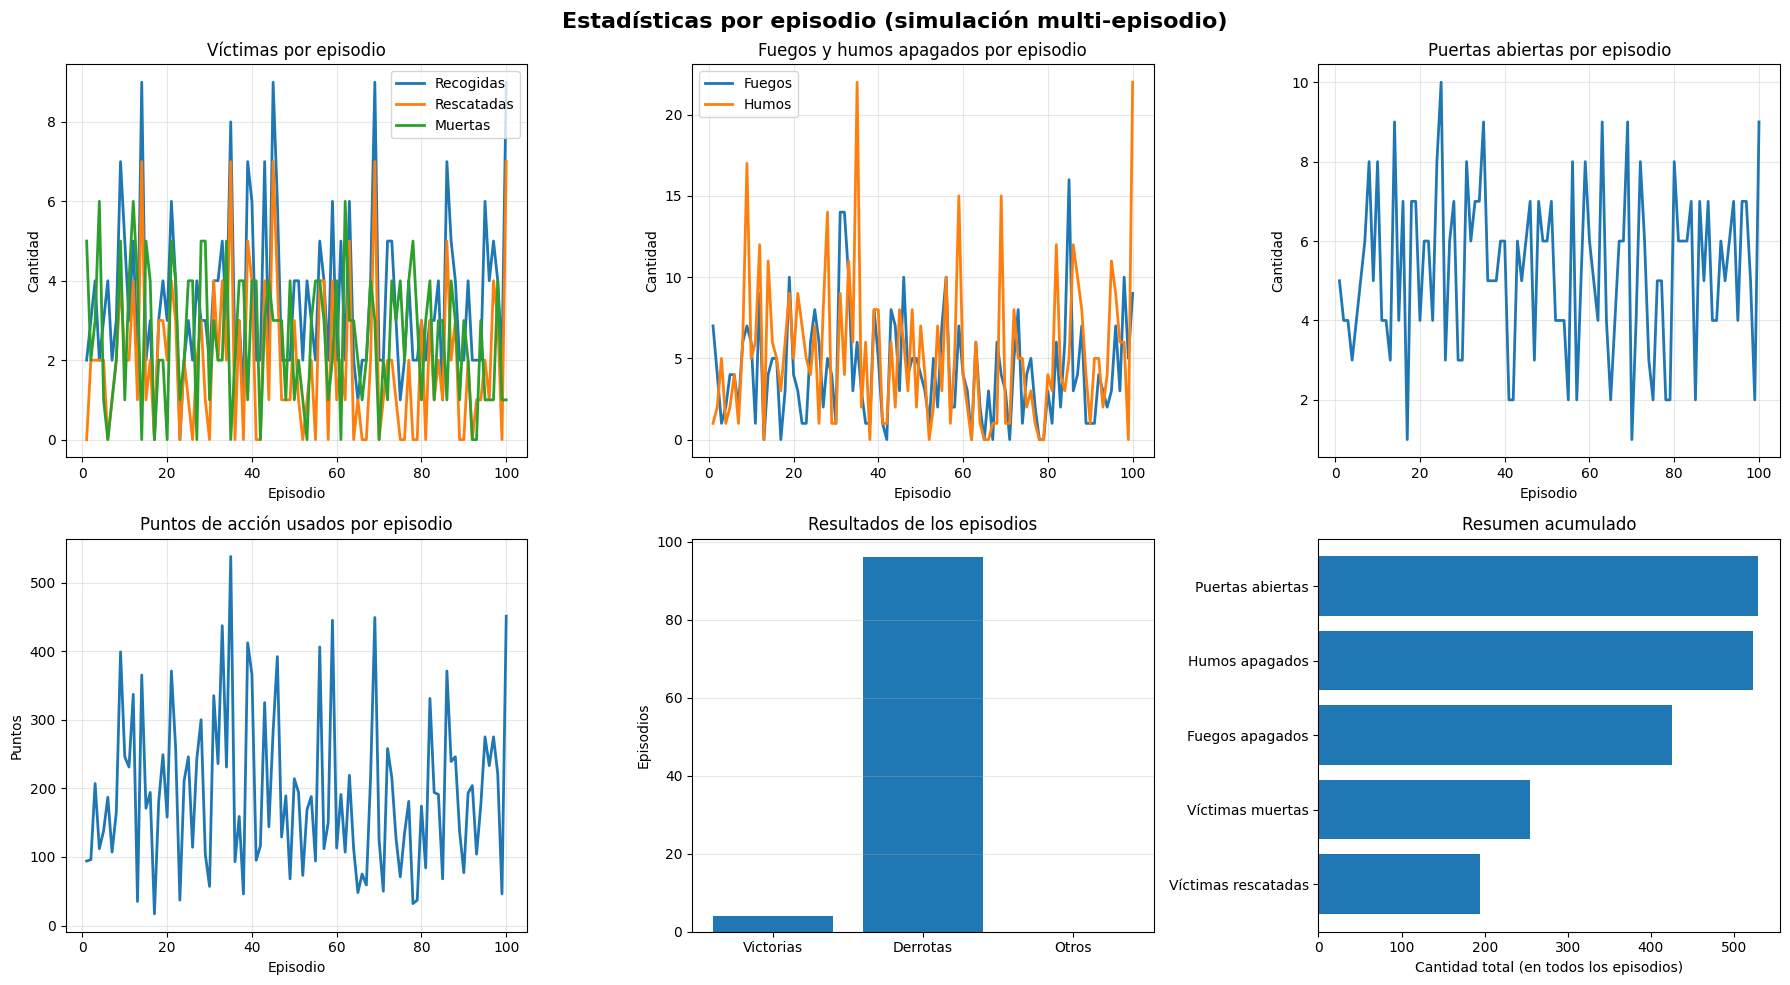

In [376]:
episodios_df = pd.DataFrame(episodios_stats)
display(episodios_df.head())

print("=" * 60)
print("RESUMEN GLOBAL DE LOS", N_EPISODIOS, "EPISODIOS")
print("=" * 60)

wins = (episodios_df["game_result"] == "win").sum()
losses = (episodios_df["game_result"] == "lose").sum()
otros = N_EPISODIOS - wins - losses

print(f"Episodios jugados: {N_EPISODIOS}")
print(f"Victorias: {wins}")
print(f"Derrotas: {losses}")
print(f"Otros resultados: {otros}")
print()

# --------- MÉTRICAS QUE NOS INTERESAN ----------
metricas = [
    "total_victims_picked",
    "victims_rescued_total",
    "victims_dead_total",
    "total_fires_extinguished",
    "total_smokes_extinguished",
    "total_doors_opened",
    "total_action_points",
]

# --------- TOTALES GLOBALES (suma en todos los episodios) ----------
print("=" * 60)
print("TOTALES ACUMULADOS (TODOS LOS EPISODIOS)")
print("=" * 60)

for m in metricas:
    print(f"{m}: {episodios_df[m].sum()}")

print()

# --------- PROMEDIOS GLOBALES ----------
print("=" * 60)
print("PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS)")
print("=" * 60)

for m in metricas:
    print(f"{m} (promedio): {episodios_df[m].mean():.2f}")

print()

# --------- STATS SOLO DE PARTIDAS GANADAS ----------
wins_df = episodios_df[episodios_df["game_result"] == "win"]

print("=" * 60)
print("STATS SOLO DE EPISODIOS GANADOS")
print("=" * 60)

if len(wins_df) == 0:
    print("No hubo victorias :(")
else:
    print(f"Episodios ganados: {len(wins_df)}\n")

    print("TOTALES ACUMULADOS (SOLO WINS):")
    for m in metricas:
        print(f"{m}: {wins_df[m].sum()}")
    print()

    print("PROMEDIOS POR EPISODIO (SOLO WINS):")
    for m in metricas:
        print(f"{m} (promedio): {wins_df[m].mean():.2f}")
    print()

# ==============================
# GRÁFICAS POR EPISODIO (igual que antes)
# ==============================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Estadísticas por episodio (simulación multi-episodio)', fontsize=16, fontweight='bold')

# 1) Víctimas por episodio
axes[0, 0].plot(episodios_df["episodio"], episodios_df["total_victims_picked"], label='Recogidas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_rescued_total"], label='Rescatadas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_dead_total"], label='Muertas', linewidth=2)
axes[0, 0].set_xlabel('Episodio')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].set_title('Víctimas por episodio')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Fuegos / humos por episodio
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_fires_extinguished"], label='Fuegos', linewidth=2)
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_smokes_extinguished"], label='Humos', linewidth=2)
axes[0, 1].set_xlabel('Episodio')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].set_title('Fuegos y humos apagados por episodio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Puertas abiertas por episodio
axes[0, 2].plot(episodios_df["episodio"], episodios_df["total_doors_opened"], linewidth=2)
axes[0, 2].set_xlabel('Episodio')
axes[0, 2].set_ylabel('Cantidad')
axes[0, 2].set_title('Puertas abiertas por episodio')
axes[0, 2].grid(True, alpha=0.3)

# 4) Puntos de acción por episodio
axes[1, 0].plot(episodios_df["episodio"], episodios_df["total_action_points"], linewidth=2)
axes[1, 0].set_xlabel('Episodio')
axes[1, 0].set_ylabel('Puntos')
axes[1, 0].set_title('Puntos de acción usados por episodio')
axes[1, 0].grid(True, alpha=0.3)

# 5) Resultados (win / lose / otros)
axes[1, 1].bar(['Victorias', 'Derrotas', 'Otros'], [wins, losses, otros])
axes[1, 1].set_ylabel('Episodios')
axes[1, 1].set_title('Resultados de los episodios')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6) Resumen total (suma en todos los episodios)
resumen_total = {
    'Víctimas rescatadas': episodios_df['victims_rescued_total'].sum(),
    'Víctimas muertas': episodios_df['victims_dead_total'].sum(),
    'Fuegos apagados': episodios_df['total_fires_extinguished'].sum(),
    'Humos apagados': episodios_df['total_smokes_extinguished'].sum(),
    'Puertas abiertas': episodios_df['total_doors_opened'].sum()
}
axes[1, 2].barh(list(resumen_total.keys()), list(resumen_total.values()))
axes[1, 2].set_xlabel('Cantidad total (en todos los episodios)')
axes[1, 2].set_title('Resumen acumulado')

plt.tight_layout()
plt.show()


In [377]:
import json
import logging
from http.server import BaseHTTPRequestHandler, HTTPServer

# -----------------------------
# Config de tipos de piso
# -----------------------------

KITCHEN_CELLS = set([
    (3,4), (3,3), (3,2),
    (4,4), (4,3), (4,2), (4,1), (3,1),
    (5,4), (5,3), (5,2), (5,1),
])

GARAGE_CELLS = set([
    (6,8), (6,7), (6,6), (6,5),
    (7,8), (7,7), (7,6), (7,5),
    (8,8), (8,7), (8,6), (8,5),
])

SAFE_CELLS = set([
    (0,0),
])

SPAWN_CELLS = set([
    (2,9), (3,9), (4,9),
    (0,0), (1,0), (2,0),
    (9,3), (9,4), (9,5),
])

# -----------------------------
# Config de episodios múltiples
# -----------------------------

N_EPISODES = 100       # cuántas partidas quieres correr
BASE_SEED = 0          # seed base, se irá incrementando

# Estado global
current_model = None
current_seed = BASE_SEED
episodes_played = 0
wins = 0
losses = 0
others = 0   # empates / cosas raras

# Stats por episodio y totales acumulados
episode_stats_list = []

total_stats = {
    "victims_rescued": 0,
    "victims_picked": 0,
    "fires_extinguished": 0,
    "smokes_extinguished": 0,
    "doors_opened": 0,
    "action_points": 0,
}

# ------------ helpers para exportar estado ------------

def build_tiles_and_edges(model):
    width, height = model.width, model.height

    tiles = []
    for x in range(width):
        for y in range(height):
            pos = (x, y)
            if pos in KITCHEN_CELLS:
                t = "kitchen"
            elif pos in GARAGE_CELLS:
                t = "garage"
            elif pos in SAFE_CELLS:
                t = "safe"
            elif pos in SPAWN_CELLS:
                t = "spawn"
            else:
                t = "inside" if pos in model.inside_cells else "outside"
            tiles.append({"x": x, "y": y, "type": t})

    edges = []
    for x in range(width):
        for y in range(height):
            from_pos = (x, y)
            for dx, dy in ((1, 0), (0, 1)):  # derecha y arriba
                nx, ny = x + dx, y + dy
                if not (0 <= nx < width and 0 <= ny < height):
                    continue
                to_pos = (nx, ny)
                edge_type = model.edges.get((from_pos, to_pos), "empty")
                if edge_type == "wall":
                    e_type = "wall"
                elif edge_type == "door_closed":
                    e_type = "door_closed"
                elif edge_type == "door_open":
                    e_type = "door_open"
                else:
                    continue
                edges.append({
                    "ax": x, "ay": y,
                    "bx": nx, "by": ny,
                    "type": e_type,
                })

    return tiles, edges


def build_hazards(model):
    hazards = []
    for x in range(model.width):
        for y in range(model.height):
            h = model.hazard_grid[x, y]
            if h == model.FIRE:
                hazards.append({"x": x, "y": y,  "kind": "fire"})
            elif h == model.SMOKE:
                hazards.append({"x": x, "y": y, "kind": "smoke"})
    return hazards


def build_agents(model):
    agents = []
    for ag in model.schedule.agents:
        x, y = ag.pos
        agents.append({
            "id": int(ag.unique_id),
            "x": int(x),
            "y": int(y),
            "role": getattr(ag, "role", None),
            "carrying_victim": bool(getattr(ag, "carrying_victim", False)),
        })
    return agents


def build_victims(model):
    victims = []
    for x in range(model.width):
        for y in range(model.height):
            if model.victim_grid[x, y]:
                victims.append({"x": x, "y": y})
    return victims


def build_full_state(model, include_tiles_edges=False):
    """
    Estado que mandamos a Unity en /floor y /step.
    """
    tiles, edges = ([], [])
    if include_tiles_edges:
        tiles, edges = build_tiles_and_edges(model)

    payload = {
        "width": model.width,
        "height": model.height,
        "tiles": tiles,
        "edges": edges,
        "hazards": build_hazards(model),
        "agents": build_agents(model),
        "victims": build_victims(model),
        "game_over": bool(model.game_over),
        "result": model.game_result,
    }
    return payload


def new_model(seed):
    """
    Crea un SimpsonStrategicModel nuevo.
    """
    return SimpsonStrategicModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,
        seed=seed,
    )


def compute_episode_stats(model):
    """
    Suma los contadores de TODOS los agentes del modelo.
    Ajusta los nombres si tus agentes usan otros.
    """
    stats = {
        "victims_rescued": 0,
        "victims_picked": 0,
        "fires_extinguished": 0,
        "smokes_extinguished": 0,
        "doors_opened": 0,
        "action_points": 0,
    }

    for ag in model.schedule.agents:
        stats["victims_rescued"]     += getattr(ag, "victims_rescued", 0)
        stats["victims_picked"]      += getattr(ag, "victims_picked", 0)
        stats["fires_extinguished"]  += getattr(ag, "fires_extinguished", 0)
        stats["smokes_extinguished"] += getattr(ag, "smokes_extinguished", 0)
        stats["doors_opened"]        += getattr(ag, "doors_opened", 0)
        stats["action_points"]       += getattr(ag, "action_points", 0)

    return stats

# ------------ handlers HTTP ------------

class FloorHandler(BaseHTTPRequestHandler):
    def do_POST(self):
        global current_model, current_seed
        global episodes_played, wins, losses, others
        global episode_stats_list, total_stats

        length = int(self.headers.get("Content-Length", 0))
        raw = self.rfile.read(length) if length > 0 else b"{}"
        try:
            data = json.loads(raw.decode("utf-8"))
        except Exception:
            data = {}

        # ----- /floor: crear modelo nuevo (reinicia la corrida de episodios) -----
        if self.path == "/floor":
            # Si mandas una seed desde Unity, úsala como base
            base_from_body = data.get("seed", None)
            if base_from_body is not None:
                BASE = int(base_from_body)
            else:
                BASE = BASE_SEED

            # reset de seeds, episodios y resultados
            current_seed = BASE
            episodes_played = 0
            wins = 0
            losses = 0
            others = 0

            # reset de stats
            episode_stats_list.clear()
            for k in total_stats:
                total_stats[k] = 0

            current_model = new_model(current_seed)

            layout = build_full_state(current_model, include_tiles_edges=True)
            # info extra de stats (Unity la ignora si no tiene campos)
            layout["episode"] = 1
            layout["wins"] = wins
            layout["losses"] = losses
            layout["others"] = others
            layout["current_seed"] = current_seed
            layout["max_episodes"] = N_EPISODES
            layout["simulation_done"] = False

            # totales en 0 al inicio
            layout["total_stats"] = total_stats
            layout["episode_finished"] = False
            layout["episode_stats"] = None

            resp_bytes = json.dumps(layout).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # ----- /step: avanzar 1 turno del modelo estratégico -----
        elif self.path == "/step":
            if current_model is None:
                self.send_response(400)
                self.end_headers()
                self.wfile.write(b'{"error": "No model. Call /floor first."}')
                return

            # Si ya jugamos todos los episodios, no avanzamos más
            if episodes_played >= N_EPISODES:
                state = build_full_state(current_model, include_tiles_edges=True)
                state["simulation_done"] = True
                state["episode"] = episodes_played
                state["wins"] = wins
                state["losses"] = losses
                state["others"] = others
                state["current_seed"] = current_seed
                state["max_episodes"] = N_EPISODES
                state["episode_finished"] = False
                state["episode_stats"] = None
                state["total_stats"] = total_stats

                resp_bytes = json.dumps(state).encode("utf-8")
                self.send_response(200)
                self.send_header("Content-Type", "application/json")
                self.send_header("Content-Length", str(len(resp_bytes)))
                self.end_headers()
                self.wfile.write(resp_bytes)
                return

            # Avanzar 1 paso
            current_model.step()

            # Construimos el estado de ESTE episodio (tablero actual)
            state = build_full_state(current_model, include_tiles_edges=True)

            # Por defecto, asumimos que el episodio sigue
            state["episode_finished"] = False
            state["episode_stats"] = None
            state["simulation_done"] = False

            # Si se terminó la partida, actualizamos stats y creamos siguiente modelo
            if current_model.game_over:
                result = getattr(current_model, "game_result", "")
                r_low = result.lower() if isinstance(result, str) else ""

                if ("win" in r_low) or ("victory" in r_low) or ("gan" in r_low):
                    wins += 1
                elif ("lose" in r_low) or ("derrota" in r_low) or ("perd" in r_low):
                    losses += 1
                else:
                    others += 1

                # --- stats de este episodio ---
                ep_stats = compute_episode_stats(current_model)
                episode_stats_list.append(ep_stats)
                for k, v in ep_stats.items():
                    total_stats[k] += v

                logging.info(f"Episode {episodes_played + 1} finished. Stats: {ep_stats}")
                logging.info(f"Total stats so far: {total_stats}")

                episodes_played += 1
                state["episode_finished"] = True
                state["episode_stats"] = ep_stats

                # Si todavía faltan episodios, preparamos el siguiente modelo
                if episodes_played < N_EPISODES:
                    current_seed += 1
                    current_model = new_model(current_seed)
                else:
                    # ya no creamos más modelos; marcamos simulación terminada
                    state["simulation_done"] = True

            # episode index que se reporta:
            if current_model.game_over:
                # acabamos de terminar un episodio; el número es episodes_played
                episode_index = episodes_played
            else:
                # estamos dentro del episodio siguiente (episodes_played ya jugados)
                episode_index = episodes_played + 1

            # Añadimos stats al JSON (Unity los ignora si StepResponse no los tiene)
            state["episode"] = episode_index
            state["wins"] = wins
            state["losses"] = losses
            state["others"] = others
            state["current_seed"] = current_seed
            state["max_episodes"] = N_EPISODES

            # totales acumulados de las partidas jugadas hasta ahora
            state["total_stats"] = total_stats

            resp_bytes = json.dumps(state).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # cualquier otra ruta
        self.send_response(404)
        self.end_headers()
        self.wfile.write(b"Not found")


def run(port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ("", port)
    httpd = HTTPServer(server_address, FloorHandler)
    logging.info(f"Starting http server on port {port}...\n")
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        pass
    httpd.server_close()
    logging.info("Stopping http server...\n")


# Lanza el servidor
run(8585)


INFO:root:Starting http server on port 8585...

127.0.0.1 - - [04/Dec/2025 01:05:15] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:35] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:38] "POS

Game Over: perdiste por dañar demasiadas paredes.


127.0.0.1 - - [04/Dec/2025 01:05:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:05:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:06:34] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:07:20] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:07:50] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:08:59] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:09:17] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:13] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:29] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:29] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:30] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:30] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/D

Game Over: perdiste por dañar demasiadas paredes.


127.0.0.1 - - [04/Dec/2025 01:12:34] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:35] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:35] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:36] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:37] "POST /step HTTP/1.1" 200 -
INFO:root:Episode 2 finished. Stats: {'victims_rescued': 1, 'victims_picked': 4, 'fires_extinguished': 2, 'smokes_extinguished': 2, 'doors_opened': 8, 'action_points': 100}
INFO:root:Total stats so far: {'victims_rescued': 4, 'victims_picked': 9, 'fires_extinguished': 7, 'smokes_extinguished': 11, 'doors_opened': 15, 'action_points': 477}


Game Over: perdiste por dañar demasiadas paredes.


127.0.0.1 - - [04/Dec/2025 01:12:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:37] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:38] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:38] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:38] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:39] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:40] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:40] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:40] "POST /step HTTP/1.1" 200 -
INFO:root:Episode 3 finished. Stats: {'victims_rescued': 3, 'victims_picked': 4, 'fires_ex

Game Over: perdiste por dañar demasiadas paredes.


127.0.0.1 - - [04/Dec/2025 01:12:40] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:40] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:41] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:41] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:41] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:41] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:42] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:42] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:42] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:42] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:43] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:43] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:43] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:44] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:44] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/202

Game Over: perdiste por dañar demasiadas paredes.


127.0.0.1 - - [04/Dec/2025 01:12:45] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 01:12:45] "POST /step HTTP/1.1" 200 -
INFO:root:Stopping http server...

